In [10]:
%load_ext autoreload
%matplotlib inline
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import sys
import os
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [12]:
if '..' not in sys.path:
    sys.path.append('..')

from short_tank_EDA.exploratory_data_analysis_utils import *

In [13]:
# Import test events from h5 file
data_path = "/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_emg_E0to1000MeV_digihits.h5"
data_file = h5py.File(data_path, "r")

print(data_file.keys())

hdf5_hit_pmt    = data_file["hit_pmt"]
hdf5_hit_time   = data_file["hit_time"]
hdf5_hit_charge = data_file["hit_charge"]


hit_pmt    = np.memmap(data_path, mode="r", shape=hdf5_hit_pmt.shape,
                                    offset=hdf5_hit_pmt.id.get_offset(), dtype=hdf5_hit_pmt.dtype)

hit_time   = np.memmap(data_path, mode="r", shape=hdf5_hit_time.shape,
                                    offset=hdf5_hit_time.id.get_offset(), dtype=hdf5_hit_time.dtype)

hit_charge = np.memmap(data_path, mode="r", shape=hdf5_hit_charge.shape,
                                    offset=hdf5_hit_charge.id.get_offset(), dtype=hdf5_hit_charge.dtype)

angles     = np.array(data_file['angles'])
energies   = np.array(data_file['energies'])
positions  = np.array(data_file['positions'])
labels     = np.array(data_file['labels'])
root_files = np.array(data_file['root_files'])

<KeysViewHDF5 ['angles', 'energies', 'event_hits_index', 'event_ids', 'hit_charge', 'hit_pmt', 'hit_time', 'labels', 'positions', 'root_files', 'veto', 'veto2']>


In [14]:
OD_veto_idxs_path = '/fast_scratch/WatChMaL/data/IWCD_mPMT_Short_3M_idxs.npz'
OD_veto_idxs = np.load(OD_veto_idxs_path, allow_pickle=True)

OD_veto_train_idxs = OD_veto_idxs['train_idxs']
OD_veto_val_idxs   = OD_veto_idxs['val_idxs']
OD_veto_test_idxs  = OD_veto_idxs['test_idxs']

In [15]:
train_angles    = angles[OD_veto_train_idxs]
train_energies  = energies[OD_veto_train_idxs]
train_positions = positions[OD_veto_train_idxs]
train_labels    = labels[OD_veto_train_idxs]

train_info = {'name':'Training Set','energies':train_energies,'positions':train_positions, 'angles':train_angles, 'labels':train_labels}

print("Done train info")

val_angles     = angles[OD_veto_val_idxs]
val_energies   = energies[OD_veto_val_idxs]
val_positions  = positions[OD_veto_val_idxs]
val_labels     = labels[OD_veto_val_idxs]

val_info = {'name':'Validation Set','energies':val_energies,'positions':val_positions, 'angles':val_angles, 'labels':val_labels}

print("Done val info")

test_angles    = angles[OD_veto_test_idxs]
test_energies  = energies[OD_veto_test_idxs]
test_positions = positions[OD_veto_test_idxs]
test_labels    = labels[OD_veto_test_idxs]
test_info = {'name':'Test Set','energies':test_energies,'positions':test_positions, 'angles':test_angles, 'labels':test_labels}

print("Done test info")

Done train info
Done val info
Done test info


In [16]:
OD_veto_dataset_info = [train_info, val_info, test_info]

In [17]:
mass_dict = {0:0, 1:0.511, 2:105.7}

In [18]:
# Compute momenta for all events

pbar = ProgressBar(widgets=['Calculating Distance to Wall. Progress: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA()], maxval=reduce(lambda x,y:x+y , list(map(lambda x : x['positions'].shape[0], OD_veto_dataset_info))))

pbar.start()
done=0
for dset in OD_veto_dataset_info:
    momenta = []
    for i in range(dset['positions'].shape[0]):
        pbar.update(done + i)
        momenta.append(compute_momenta(dset['energies'][i][0], mass_dict[dset['labels'][i]]))
        dset['momenta'] = momenta
    done = done + dset['positions'].shape[0]
pbar.finish()

np.savez('./fq_comparison_data/3M_momenta.npz',      train_momenta= OD_veto_dataset_info[0]['momenta'],
                                                     val_momenta  = OD_veto_dataset_info[1]['momenta'],
                                                     test_momenta = OD_veto_dataset_info[2]['momenta'])


Calculating Distance to Wall. Progress: 100% [000000000000000000] Time: 0:01:19


In [19]:
momenta_data = np.load('./fq_comparison_data/3M_momenta.npz', allow_pickle=True)

test_momenta = momenta_data['test_momenta']

In [20]:
print(test_energies[0:10])

[[245.00162]
 [855.76855]
 [597.02356]
 [402.78616]
 [830.34595]
 [298.88596]
 [110.14116]
 [543.9056 ]
 [632.63806]
 [286.20142]]


In [21]:
print(test_momenta[0:10])

[245.00108453 855.76840212 597.02334088 402.78583919 830.34579003
 298.88551899 110.13997366 543.90533857 632.63785515 286.20095983]


(array([267517., 347809., 408425., 410220., 410470., 410289., 411370.,
        411925., 309436., 137021.]),
 array([   1.4282632,  117.3111   ,  233.19392  ,  349.07675  ,
         464.9596   ,  580.8424   ,  696.7253   ,  812.6081   ,
         928.4909   , 1044.3738   , 1160.2566   ], dtype=float32),
 <BarContainer object of 10 artists>)

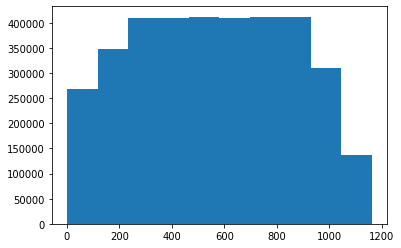

In [22]:
plt.hist(test_energies)

(array([266164., 372147., 398425., 404338., 405840., 406687., 408721.,
        408798., 317535., 135827.]),
 array([   1.33372213,  116.74353963,  232.15335713,  347.56317462,
         462.97299212,  578.38280961,  693.79262711,  809.2024446 ,
         924.6122621 , 1040.02207959, 1155.43189709]),
 <BarContainer object of 10 artists>)

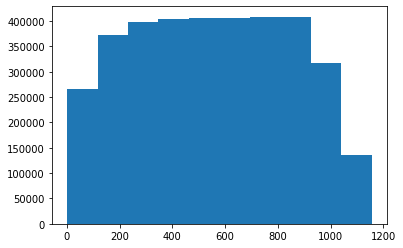

In [23]:
plt.hist(test_momenta)